In [1]:
import torch
import torch.nn as nn
import numpy as np

import os
import imageio
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from new_datasets import data_preprocessing
from model import Voxels,Nerf
from ml_helpers import training
import rendering

In [2]:
data_set_path = '/home/eiyike/Desktop/phdproject/MY_NERf2222/new_code_update1/Dataset'


mode = 'train'

In [3]:
target_size = (400,400)
dataset = data_preprocessing(data_set_path,mode,target_size=target_size)

focal_length:  555.5555155968841
(100, 4, 4)
[[-0.99029607  0.0917614  -0.10437164 -0.4207356 ]
 [-0.13897336 -0.65387315  0.7437312   2.99807668]
 [ 0.          0.75101906  0.66028041  2.66167569]
 [ 0.          0.          0.          1.        ]]
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
size:  (100, 400, 400, 4)
size:  (100, 400, 400, 3)


In [4]:
o, d, target_px_values,total_data = dataset.get_rays()

100 160000


In [5]:
batch_size = 1024

dataloader = DataLoader(
    torch.cat(
              (torch.from_numpy(o).reshape(-1, 3).type(torch.float),
               torch.from_numpy(d).reshape(-1, 3).type(torch.float),
               torch.from_numpy(target_px_values).reshape(-1, 3).type(torch.float)
               ), dim=1),
              batch_size=batch_size, shuffle=True)

In [6]:
size_h, size_w = target_size
dataloader_warmup = DataLoader(
    torch.cat(
        (torch.from_numpy(o).reshape(total_data, size_h, size_w, 3)[:, 100:300, 100:300, :].reshape(-1, 3).type(torch.float),
         torch.from_numpy(d).reshape(total_data, size_h, size_w, 3)[:, 100:300, 100:300, :].reshape(-1, 3).type(torch.float),
        torch.from_numpy(target_px_values).reshape(total_data, size_h, size_w, 3)[:, 100:300, 100:300, :].reshape(-1, 3).type(torch.float)
         ), dim=1),
        batch_size=batch_size, shuffle=True)

In [8]:
device = 'cuda'

tn = 2
tf = 6
nb_epochs = 1
lr = 1e-3
gamma = .5
nb_bins = 100

model = Nerf(hidden_dim=128).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[5, 10], gamma=gamma)

100%|██████████| 3907/3907 [04:13<00:00, 15.40it/s]


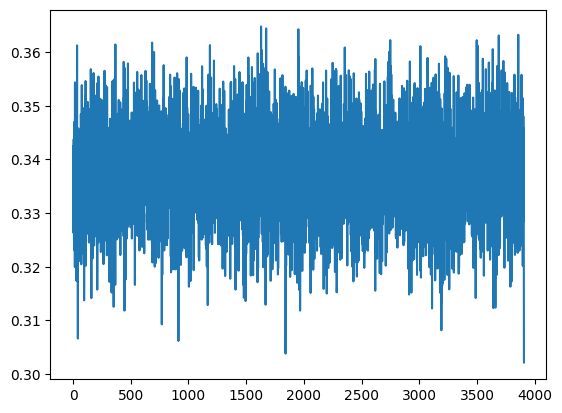

In [9]:
training_loss = training(model, optimizer, scheduler, tn, tf, nb_bins, 1, dataloader_warmup, device=device)
plt.plot(training_loss)
plt.show()

100%|██████████| 15625/15625 [16:38<00:00, 15.65it/s]


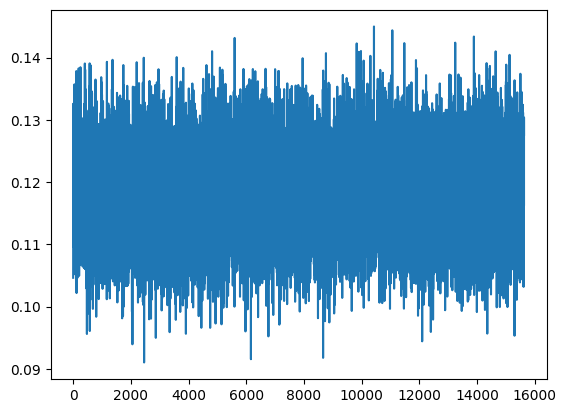

In [10]:
training_loss = training(model, optimizer, scheduler, tn, tf, nb_bins, nb_epochs, dataloader, device=device)
plt.plot(training_loss)
plt.show()

In [13]:
img = rendering.rendering(model, torch.from_numpy(o[0]).type(torch.float).to(device), torch.from_numpy(d[0]).type(torch.float).to(device),
                tn, tf, nb_bins=10, device=device)
plt.imshow(img.reshape(400, 400, 3).data.cpu().numpy())



RuntimeError: CUDA out of memory. Tried to allocate 782.00 MiB (GPU 0; 23.69 GiB total capacity; 21.54 GiB already allocated; 443.69 MiB free; 21.56 GiB reserved in total by PyTorch)